In [1]:
import torch 
import numpy as np
from numpy.ma.core import outer
from sys import stderr
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.pyplot import scatter, figure
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import seaborn as sns
sns.set(rc={'figure.figsize':(4, 4)})

import warnings

warnings.filterwarnings('ignore')


In [2]:
batch_size = 3
start      = 0.0
end        = 1.4

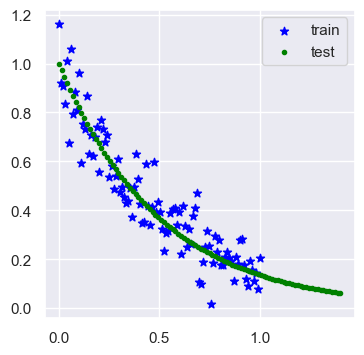

In [27]:
def sample_dataset(start, end, n, noise=0.1):
    
    x = np.linspace(start, end, n)
    sample_mean = np.exp(-2*x) 
    sample_var = noise*np.ones_like(sample_mean) 
    # sample_var = [abs((abs(start)+abs(end))/2 - abs(i))/16 for i in x]
    y = stats.norm(sample_mean, sample_var).rvs(random_state=1)
    return x, y


x_train, y_train = sample_dataset(0, 1, 100)

figure(figsize=(4, 4))
# Not exactly the same distribution, but works for now
x_test, y_test = sample_dataset(start, end, 100, noise = 0.0)
scatter(x_train, y_train, c="blue", marker="*", label ='train')
scatter(x_test, y_test, c="green", marker=".", label = 'test')
plt.legend()

In [28]:
# Train
tensor_x_train = torch.Tensor(x_train).unsqueeze(1)
tensor_y_train = torch.Tensor(y_train).unsqueeze(1)
train_dataset = TensorDataset(tensor_x_train, tensor_y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Test
tensor_x_test = torch.Tensor(x_test).unsqueeze(1)
tensor_y_test = torch.Tensor(y_test).unsqueeze(1)
test_dataset = TensorDataset(tensor_x_test, tensor_y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [42]:
class Experiment(nn.Module):
    def __init__(self):
        super(Experiment, self).__init__()

        self.optimizer = None
        self.train_loss_history = []
        
        self.hidden_size = 15
        self.t0 = torch.tensor([0.0], requires_grad=True)
        self.y0 = torch.tensor([1.0], requires_grad=True)
        self.predicted_params = 1.0
    

        # We only have 1 input feature
        self.b1 = nn.Linear(1, self.hidden_size)
        self.b2 = nn.Linear(self.hidden_size, self.hidden_size)
        self.b3 = nn.Linear(self.hidden_size, 1)

        self.t1 = nn.Linear(1, self.hidden_size)
        self.t2 = nn.Linear(self.hidden_size, self.hidden_size)
        self.t3 = nn.Linear(self.hidden_size, 1)
        
        nn.init.ones_(self.b1.weight)
        nn.init.ones_(self.b2.weight)
        nn.init.ones_(self.b3.weight)
        
        nn.init.ones_(self.t1.weight)
        nn.init.ones_(self.t2.weight)
        nn.init.ones_(self.t3.weight)
        
    def forward(self, t):
        if not torch.is_tensor(t):         
            t = torch.from_numpy(t)                
        
        t = t.float()
        
        h1 = torch.tanh(self.b1(t))
        h2 = torch.tanh(self.b2(h1))


        prior_param_sample = torch.rand(1,1).requires_grad_(True)
        t1 = torch.tanh(self.t1(prior_param_sample))
        t2 = torch.tanh(self.t2(t1))
        y = self.b3(torch.multiply(t2,h2))
        # posterior_param_sample = self.t3(torch.multiply(t2,h2))
        posterior_param_sample =  self.t3(t2)
        self.predicted_params  =  posterior_param_sample
        # print(posterior_param_sample.shape)
        return y

    def sample_parameter_posterior(self, num_samples=50):
        prior_param_sample     = torch.rand(num_samples,1).requires_grad_(True)
        posterior_param_sample = self.t3(torch.tanh(self.t2(torch.tanh(self.t1(prior_param_sample)))))
        return posterior_param_sample
        
    def compute_derivative(self, y, x, n):
        # General formula to compute the n-th order derivative of y = f(x) with respect to x
        if n == 0:
            return y
        else:
            dy_dx = torch.autograd.grad(y, x, torch.ones_like(y).to(device),
                                        create_graph=True, retain_graph=True,
                                        allow_unused=True)[0]
            
        return self.compute_derivative(dy_dx, x, n - 1)

    def PDE_residual(self, t):
        # Compute the differential equation residual
        y      = self.forward(t)
        dy_dt  = self.compute_derivative(y, t, 1)

        residual = dy_dt  + self.predicted_params*y
        return residual

    def loss_initial_condition(self):
        y0_pred    = self.forward(self.t0)
        loss_ic    = torch.mean(torch.square(self.y0 - y0_pred))
        return loss_ic

    def compute_losses(self):

        loss_ic       = self.loss_initial_condition()
        loss_interior = self.loss_interior()
        loss_data     = self.loss_data()
        # mse_BC = self.loss_BC()

        return loss_ic, loss_interior, loss_data


    def loss_data(self, num_samples = 100):
        # t_data = torch.linspace(0,1,num_samples).reshape(-1,1).to(device).requires_grad_(True)
        # y_data = torch.exp(-2.0*t_data) 
        t_data, y_data = next(iter(train_loader))
        y_pred = self.forward(t_data)
        loss   = torch.mean(torch.square(y_pred-y_data))
        return loss
        
    def loss_interior(self, num_samples = 100):
        interior_time_samples = torch.FloatTensor(num_samples, 1).uniform_(0, 1).requires_grad_(True)
        res = self.PDE_residual(interior_time_samples)
        loss_residual = torch.mean(torch.square(res))
        
        return loss_residual
        
    def closure(self, w1 = 1, w2=1, w3=2):
        self.optimizer.zero_grad()
        loss_ic, loss_interior, loss_data = self.compute_losses()
        total_loss = w1*loss_ic + w2*loss_interior  + w3*loss_data
        total_loss.backward(retain_graph=True)
        return total_loss

    def train(self, epochs, optimizer='Adam', **kwargs):

        if optimizer=='Adam':
            self.optimizer = torch.optim.Adam(self.parameters(), **kwargs)

        elif optimizer=='L-BFGS':
            self.optimizer = torch.optim.LBFGS(self.parameters(), **kwargs)

        # Training loop
        for epoch in range(epochs):


            self.optimizer.step(self.closure)

            if epoch % 1000 == 0:
                loss_ic, loss_interior, loss_data = self.compute_losses()
                total_loss = loss_ic + loss_interior + loss_data
            
            # self.train_loss_history.append([total_loss.cpu().detach(),
            #                                 loss_ic.cpu().detach(),
            #                                 loss_interior.cpu().detach()])
                print(f'Epoch ({optimizer}): {epoch}, Total Loss: {total_loss.detach().cpu().numpy()}')
            
    def get_training_history(self):
        loss_hist = np.array(self.train_loss_history)
        total_loss, loss_ic, loss_interior, loss_data = np.split(loss_hist, 3, axis=1)
        return total_loss, loss_ic, loss_interior, loss_data

        
    # def compute_Jacobina(self, x):
    #     self.dy_dx = torch.autograd.functional.jacobian(self, x, create_graph=True)
    #     self.dy_dx = torch.squeeze(self.dy_dx)
    #     return self.dy_dx

   # def loss_BC(self):
   #      y_pred_BC1 = self.network_prediction(self.t_lb, self.x_lb)
   #      mse_BC1 = torch.mean((self.y_lb - y_pred_BC1)**2)
        
   #      y_pred_BC2 = self.network_prediction(self.t_ub, self.x_ub)
   #      mse_BC2 = torch.mean((self.y_ub - y_pred_BC2)**2)
        
   #      mse_BC = mse_BC1 + mse_BC2
   #      return mse_BC

    def make_plot(self):
        # Get predictions
        mu = self.forward(tensor_x_test)
    
        # Create DF from predictions
    
        data = {
                  "x": list(tensor_x_test.squeeze().detach().numpy()),
                  "y": list(mu.squeeze().detach().numpy())
            }
        temp = pd.DataFrame.from_dict(data)
    
        # Plot predictions with confidence
        sns_plot = sns.lineplot(data=temp, x="x", y="y", c='r')
    
        # Highlight training range
        plt.axvline(x=start)
        plt.axvline(x=end)
    
        # Plot test data on top
        scatter(x_test, y_test, c="green", marker="*", alpha=0.5)
        plt.show()

In [43]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [44]:
net = Experiment()
print(net)
print("Params:", sum(p.numel() for p in net.parameters() if p.requires_grad))

Experiment(
  (b1): Linear(in_features=1, out_features=15, bias=True)
  (b2): Linear(in_features=15, out_features=15, bias=True)
  (b3): Linear(in_features=15, out_features=1, bias=True)
  (t1): Linear(in_features=1, out_features=15, bias=True)
  (t2): Linear(in_features=15, out_features=15, bias=True)
  (t3): Linear(in_features=15, out_features=1, bias=True)
)
Params: 572


In [45]:
x, y  = next(iter(test_loader))

In [48]:
net.train(10000, lr=1e-3)

Epoch (Adam): 0, Total Loss: 0.008790923282504082
Epoch (Adam): 1000, Total Loss: 0.0009993744315579534
Epoch (Adam): 2000, Total Loss: 0.009583096951246262
Epoch (Adam): 3000, Total Loss: 0.004869346506893635
Epoch (Adam): 4000, Total Loss: 0.018911749124526978
Epoch (Adam): 5000, Total Loss: 0.0022238539531826973
Epoch (Adam): 6000, Total Loss: 0.0216490738093853
Epoch (Adam): 7000, Total Loss: 0.0012663444504141808
Epoch (Adam): 8000, Total Loss: 0.011876358650624752
Epoch (Adam): 9000, Total Loss: 0.009694932959973812


In [49]:
net(x) - torch.exp(-2*x)

tensor([[0.0115],
        [0.0092],
        [0.0107]], grad_fn=<SubBackward0>)

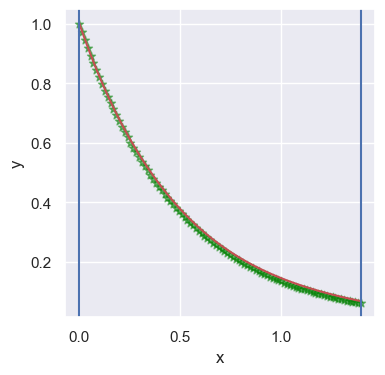

In [50]:
net.make_plot()

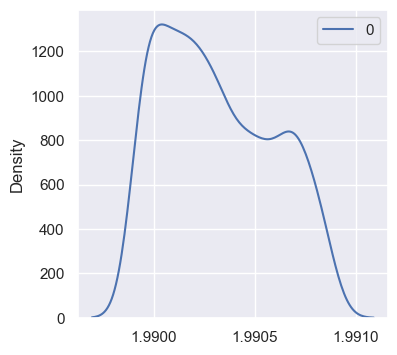

In [51]:
samples = net.predicted_params.detach().cpu()
samples = net.sample_parameter_posterior(num_samples=1000).detach().cpu()
g  = sns.kdeplot(samples)


In [371]:
net.predicted_params.mean(), net.predicted_params.std()

(tensor(2.4110e-05, grad_fn=<MeanBackward0>),
 tensor(nan, grad_fn=<StdBackward0>))